# AIPI 590 - XAI | Assignment #05
### Description  
Assignment 5 - Explainable Techniques:

Generate local explanations for individual predictions from a pre-trained blackbox model

### Keese Phillips  
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/github.com/keesephillips/aipi590_xai/blob/main/assignment5.ipynb)

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "aipi590_xai"
git_path = 'https://github.com/keesephillips/aipi590_xai'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

notebook_dir = 'assignment_5'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [23]:
import torch
import pandas as pd
import numpy as np
import random
from PIL import Image
from lime import lime_image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
# FashionMNIST Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.ToPILImage()
])

In [1]:
# Load Fashion MNIST dataset
labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

num_classes = len(labels)
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    """

    Train the model with the FashionMNIST training set then 
    test the model on the test set and output the 
    model accuracy

    """
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')
    return model

# Load the ResNet34 Pretrained model
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

100%|██████████| 26421880/26421880 [00:10<00:00, 2640288.88it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175993.25it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1184005.18it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22704812.82it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 99.9MB/s]


Epoch [1/5], Loss: 0.3231
Epoch [2/5], Loss: 0.2186
Epoch [3/5], Loss: 0.1820
Epoch [4/5], Loss: 0.1551
Epoch [5/5], Loss: 0.1333
Accuracy of the model on the test set: 93.02%


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

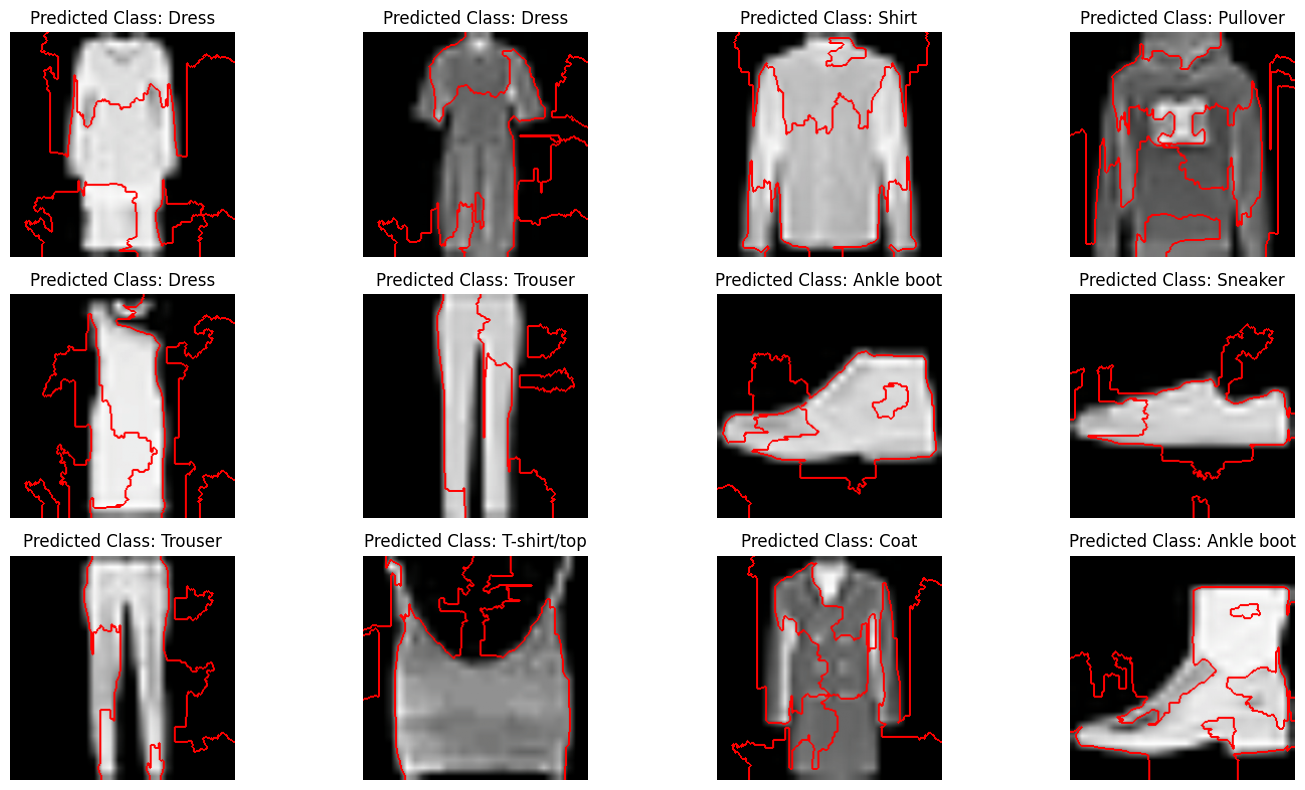

In [58]:
def predict(image):
    """
    
    Generate the predictions on the image from
    the model 
    
    """
    with torch.no_grad():
        output = model(image)
    return output

def explain_image(image):
    """
    
    Implement the LIME Image Explainer and output the image with the 
    mask to explain the local decision boundary of the model in 
    reference to the image
    
    """
    explainer = lime_image.LimeImageExplainer(kernel_width=0.25)

    explanation = explainer.explain_instance(
        np.array(image.squeeze(0).permute(1, 2, 0).cpu()),
        lambda x: predict(torch.tensor(x).permute(0, 3, 1, 2).float().to(device)).cpu().detach().numpy(),
        top_labels=5,
        hide_color=0,
        num_samples=2500
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    temp = torch.from_numpy(temp).permute(2, 0, 1)
    temp = inverse_transform(temp)
    temp = np.array(temp)

    img_boundary = mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick')

    predicted_class_index = explanation.top_labels[0]

    return img_boundary, labels[predicted_class_index]


fig, axs = plt.subplots(3, 4, figsize=(15, 8))
for i in range(12):
    random_index = random.randint(0, len(train_dataset) - 1)
    random_image_tensor, _ = train_dataset[random_index]
    explanation_image, label = explain_image(random_image_tensor.unsqueeze(0).to(device))
    axs[i // 4, i % 4].imshow(explanation_image)
    axs[i // 4, i % 4].set_title(f'Predicted Class: {label}')
    axs[i // 4, i % 4].axis('off')

plt.tight_layout()
plt.show()


# Discussion
In this assignment, I implemented LIME so that I could visualize the local decision boundary. In the visualization above, one sees how the local decision boundary could contribute to the prediction of several classes. For example, the bag has a local decision boundary around the handle, whereas the ankle boot has a decision boundary around the heel. LIME in particular works well with tabular, text, and image data making it very useful for visualizing local decision boundaries of many different deep neural networks. In particular LIME can help one to visualize the local decision boundary of the deepest CNNs that have many layers. A limitation of LIME is the difficulty setting the kernel width. In particular, for this problem I had difficulty setting the kernel width to maximize the ability of LIME to visualize the local boundary. Another limitation is the local decision boundary does not explain the entire decision boundary of the model. A possible improvement to this implementation of LIME would be to search for the best kernel width, that is the kernel width that displays the local decision boundary in the most explainable way.